<a href="https://colab.research.google.com/github/AndresMontesDeOca/Laboratorio3/blob/main/Kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modulos

## Libraries

In [1]:
# ColabNotebook = 'google.colab' in str(get_ipython())

# if ColabNotebook: # maquina virtual colab
#     # monta G-drive en entorno COLAB
#     from google.colab import drive
#     drive.mount('/content/drive/')

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error


import warnings
# warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore')

# Asegurarte de que Pandas muestre los valores con la máxima precisión
pd.set_option('display.float_format', lambda x: '%.10f' % x)

# Ajustar la opción para mostrar más filas
# pd.set_option('display.max_rows', None)

# Si también quieres mostrar más columnas
# pd.set_option('display.max_columns', None)


# Vamos a suprimir la notacion cientifica
pd.set_option("display.float_format", lambda x:"%.2f" %x)


## Carga Datos

In [3]:
# Code to read csv file into Colaboratory:
# !pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth, drive
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)



################################# Datasets ###################################
# # Ventas
id = "158aOjqxaNO8l97yA6VWJkek_15YVLMhs"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('sell-in.txt')
data_ventas = pd.read_csv("sell-in.txt", sep="\t")
data_ventas['periodo'] = pd.to_datetime(data_ventas['periodo'], format='%Y%m')
data_ventas['customer_id'] = data_ventas['customer_id'].astype(str)
data_ventas['product_id'] = data_ventas['product_id'].astype(str)
data = data_ventas.copy()

# # Productos
id = "15JS_k86LS0sgJXma7BOVXWlyNcMwxdhE"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('tb_productos.txt')
data_productos = pd.read_csv("tb_productos.txt", sep="\t")
data_productos['product_id'] = data_productos['product_id'].astype(str)

# # Stocks
id = "15EV-8f_U7onpA1AcTxxXeD-z8yVR4fQu"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('tb_stocks.txt')
data_stocks = pd.read_csv("tb_stocks.txt", sep="\t")
data_stocks['periodo'] = pd.to_datetime(data_stocks['periodo'], format='%Y%m')
data_stocks['product_id'] = data_stocks['product_id'].astype(str)

# # Productos a predecir
id = "15LjADctFVwjzQFJvfJGFTEdgZx9xCoId"
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('productos_a_predecir.txt')
data_productos_a_predecir = pd.read_csv("productos_a_predecir.txt", sep="\t")
data_productos_a_predecir['product_id'] = data_productos_a_predecir['product_id'].astype(str)
data_productos_a_predecir_con_categorias = data_productos_a_predecir.set_index('product_id').join(data_productos.drop_duplicates('product_id').set_index('product_id').sort_index()[['cat1', 'cat2', 'cat3']])




## Filter Data

In [4]:
##############################################################################
def filter_data(data_all, data_filter):
    # Filtrar el DataFrame 'data_all' para que solo contenga los 'product_id' presentes en 'data_filter'
    data_filtered = data_all[data_all['product_id'].isin(data_filter['product_id'])]

    return data_filtered
##############################################################################
def filter_data_por_categoria(df, categoria, categoria_columna):
    """
    Filtra los productos de un DataFrame dado una categoría y el DataFrame de productos con categorías.

    Args:
    dataframe (pd.DataFrame): DataFrame con las ventas de productos (cada columna es un product_id).
    categoria (str): Categoría a filtrar (valor de cat1, cat2 o cat3).
    categoria_columna (str): Nombre de la columna de categoría ('cat1', 'cat2' o 'cat3').

    Returns:
    pd.DataFrame: DataFrame filtrado con solo los productos de la categoría especificada.
    """
    # Filtrar los productos que pertenecen a la categoría especificada
    productos_filtrados = data_productos_a_predecir_con_categorias[data_productos_a_predecir_con_categorias[categoria_columna] == categoria].index

    # Filtrar el DataFrame de ventas usando los product_ids de los productos filtrados
    productos_en_data = [col for col in df.columns if col in productos_filtrados]
    df_filtrado = df[productos_en_data]

    return df_filtrado
##############################################################################

## Plot History

In [5]:
#############################################################################
def plot_history(history, start_epoch=0, metrics=None):
    if isinstance(metrics, str):
        metrics = [metrics]

    if metrics is None:
        metrics = [x for x in history.history.keys() if x[:4] != 'val_']

    if len(metrics) == 0:
        print('No metrics to display.')
        return

    # Get the epochs and filter them starting from start_epoch
    x = history.epoch[start_epoch:]

    rows = 1
    cols = len(metrics)
    count = 0

    plt.figure(figsize=(12 * cols, 8))

    for metric in sorted(metrics):
        count += 1
        plt.subplot(rows, cols, count)
        plt.plot(x, history.history[metric][start_epoch:], label='Train')
        val_metric = f'val_{metric}'
        if val_metric in history.history.keys():
            plt.plot(x, history.history[val_metric][start_epoch:], label='Validation')
        plt.title(metric.capitalize())
        plt.legend()
    plt.show()
################################################################

## Group Data

In [6]:
# Siempre como values toma las toneladas vendidas
def group_data(data, column):
  grouped_data = data.groupby([column, 'periodo']).sum().reset_index()

  # Crea un DataFrame pivoteado donde las filas son las fechas y las columnas son los product_id
  pivot_data = grouped_data.pivot(index='periodo', columns=column, values='tn')

  # Asegúrate de que los nombres de las columnas sean strings
  pivot_data.columns = pivot_data.columns.astype(str)

  # Restablece el índice para asegurarse de que 'product_id' no sea un índice compuesto
  pivot_data.columns.name = None

  return pivot_data

## Fill Nulls

In [7]:
# Jugar con esto, no se si esta bien
def fill_nulls(df):
  # Primero usamos bfill para completar las ordenes mas viejas con los valores de las ordenes mas recientes
  df = df.bfill()
  # Luego completamos con ceros los productos que dejamos de vender, o se discontinuaron
  df = df.fillna(0)

  return df
###########################################################################
def fill_nulls_customer(df):
  df = df.fillna(0)
  return df


## Normalize Data

In [8]:
# Hay que modificarlo, fit_transform en Train, y transform en Test

import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler

def normalize_data(df, normalization="MinMax"):
    """
    Normaliza cada serie de tiempo (columna) de manera individual usando MinMax o Zscore.

    Args:
        df (pd.DataFrame): DataFrame con series de tiempo de distintos productos, cada columna es un producto.
        normalization (str): Tipo de normalización a aplicar. Opciones: "MinMax" o "Zscore". Default es "MinMax".

    Returns:
        normalized_df (pd.DataFrame): DataFrame con las series normalizadas.
        normalization_params (pd.DataFrame): DataFrame con los parámetros necesarios para desnormalizar cada columna.
            - Para "MinMax": valores min y max de cada columna.
            - Para "Zscore": valores mean y std de cada columna.
    """
    normalization_params = pd.DataFrame(columns=["product_id", "min", "max", "mean", "std"])
    normalized_df = pd.DataFrame(index=df.index)

    for column in df.columns:
        if normalization == "MinMax":
            scaler = MinMaxScaler()
            normalized_values = scaler.fit_transform(df[[column]]).flatten()
            new_params = pd.DataFrame({
                "product_id": [column],
                "min": [scaler.data_min_[0]],
                "max": [scaler.data_max_[0]],
                "mean": [None],
                "std": [None]
            })
            normalization_params = pd.concat([normalization_params, new_params], ignore_index=True)
            normalized_df[column] = normalized_values

        elif normalization == "ZScore":
            scaler = StandardScaler()
            normalized_values = scaler.fit_transform(df[[column]]).flatten()
            new_params = pd.DataFrame({
                "product_id": [column],
                "min": [None],
                "max": [None],
                "mean": [scaler.mean_[0]],
                "std": [scaler.scale_[0]]
            })
            normalization_params = pd.concat([normalization_params, new_params], ignore_index=True)
            normalized_df[column] = normalized_values

        else:
            raise ValueError("Invalid normalization method. Choose 'MinMax' or 'ZScore'.")

    return normalized_df, normalization_params

def denormalize_series(normalized_series, normalization_params, normalization="MinMax"):
    """
    Desnormaliza una serie de tiempo usando los valores almacenados.

    Args:
        normalized_series (pd.Series or pd.DataFrame): Serie o DataFrame con los datos normalizados.
        normalization_params (pd.DataFrame): DataFrame con los parámetros necesarios para desnormalizar cada serie o columna.
            - Para "MinMax": valores min y max de cada serie o columna.
            - Para "Zscore": valores mean y std de cada serie o columna.
        normalization (str): Tipo de normalización a deshacer. Opciones: "MinMax" o "Zscore". Default es "MinMax".

    Returns:
        denormalized_series (pd.Series or pd.DataFrame): Serie o DataFrame con los datos desnormalizados.
    """
    if isinstance(normalized_series, pd.DataFrame):
        denormalized_df = pd.DataFrame(index=normalized_series.index)
        for column in normalized_series.columns:
            params = normalization_params[normalization_params["product_id"] == column]
            if normalization == "MinMax":
                min_value = params["min"].values[0]
                max_value = params["max"].values[0]
                denormalized_values = normalized_series[column] * (max_value - min_value) + min_value
            elif normalization == "ZScore":
                mean_value = params["mean"].values[0]
                std_value = params["std"].values[0]
                denormalized_values = normalized_series[column] * std_value + mean_value
            else:
                raise ValueError("Invalid normalization method. Choose 'MinMax' or 'ZScore'.")
            denormalized_df[column] = denormalized_values
        return denormalized_df
    elif isinstance(normalized_series, pd.Series):
        product_ids = normalized_series.index
        denormalized_values = []
        for product_id in product_ids:
            params = normalization_params[normalization_params["product_id"] == product_id]
            if normalization == "MinMax":
                min_value = params["min"].values[0]
                max_value = params["max"].values[0]
                denormalized_value = normalized_series[product_id] * (max_value - min_value) + min_value
            elif normalization == "ZScore":
                mean_value = params["mean"].values[0]
                std_value = params["std"].values[0]
                denormalized_value = normalized_series[product_id] * std_value + mean_value
            else:
                raise ValueError("Invalid normalization method. Choose 'MinMax' or 'ZScore'.")
            denormalized_values.append(denormalized_value)
        denormalized_series = pd.Series(denormalized_values, index=product_ids, name=normalized_series.name)
        return denormalized_series
    else:
        raise TypeError("normalized_series should be either a pandas Series or DataFrame")


## Split Data

In [9]:
###############################################################################
# el split de validacion es lo mas chico posible para que no tire error
def split_data(df):
  df_train = df.loc['2017-01':'2019-05']
  df_valid = df.loc['2019-06':'2019-12']
  return df_train, df_valid
#############################################################################
def split_data_dec2019(df):
  df_train = df.loc['2017-01':'2019-10']
  df_valid = df.loc['2019-11':'2019-12']
  return df_train, df_valid
############################################################################
def split_data_2019(df):
  df_train = df.loc['2017-01':'2018-12']
  df_valid = df.loc['2019-01':'2019-12']
  return df_train, df_valid

## Window Data

In [10]:
#############################################################################
def windowed_dataset(sequence, data_split, window_size, horizon, batch_size, shuffle_buffer=1000):
    """Generates dataset windows.

    Args:
      sequence (array-like): Contains the values of the time series.
      data_split (str): Specifies if the dataset is for training or validation/test.
      window_size (int): The number of time steps to include in the feature.
      horizon (int): The number of future time steps to predict.
      batch_size (int): The batch size.
      shuffle_buffer (int): Buffer size to use for the shuffle method.

    Returns:
      tf.data.Dataset: TF Dataset containing time windows.
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(sequence)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + horizon, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + horizon))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-horizon], window[-horizon:]))

    if data_split == 'train':
        # Shuffle the training data to improve generalization
        dataset = dataset.shuffle(shuffle_buffer)
    else:
        # Cache the validation/test data for improved performance
        dataset = dataset.cache()

    # Create batches of windows and prefetch for performance
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return dataset

In [11]:
##############################################
# # Viejos
##############################################
# def window_dataset(sequence, data_split, window_size, batch_size, n_future, shuffle_buffer=1000, seed=None):
#     dataset = tf.data.Dataset.from_tensor_slices(sequence)
#     dataset = dataset.window(window_size + n_future, shift=1, drop_remainder=True)
#     dataset = dataset.flat_map(lambda window: window.batch(window_size + n_future))
#     dataset = dataset.map(lambda window: (window[:window_size], window[window_size:]))

#     if data_split == 'train':
#         dataset = dataset.shuffle(shuffle_buffer, seed=seed)
#     else:
#         dataset = dataset.cache()

#     dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

#     return dataset
##############################################
# def window_dataset(sequence, data_split, window_size, batch_size, n_future, shuffle_buffer=1000, seed=None):
#     """Generates dataset windows for multi-step forecasting in a multivariable context.

#     Args:
#       sequence (array-like): Contains the values of the time series, where each element is an array of feature values.
#       data_split (str): Specifies if the dataset is for training or validation/test.
#       window_size (int): The number of time steps to include in the feature.
#       batch_size (int): The batch size.
#       n_future (int): The number of future steps to predict.
#       shuffle_buffer (int): Buffer size to use for the shuffle method.
#       seed (int, optional): Random seed for reproducibility.

#     Returns:
#       tf.data.Dataset: TF Dataset containing time windows.
#     """

#     # Generate a TF Dataset from the series values
#     dataset = tf.data.Dataset.from_tensor_slices(sequence)

#     # Window the data but only take those with the specified size
#     dataset = dataset.window(window_size + n_future, shift=1, drop_remainder=True)

#     # Flatten the windows by putting its elements in a single batch
#     dataset = dataset.flat_map(lambda window: window.batch(window_size + n_future))

#     # Create tuples with features and labels
#     dataset = dataset.map(lambda window: (window[:window_size], window[window_size:]))

#     if data_split == 'train':
#         # Shuffle the training data to improve generalization
#         dataset = dataset.shuffle(shuffle_buffer, seed=seed)
#     else:
#         # Cache the validation/test data for improved performance
#         dataset = dataset.cache()

#     # Create batches of windows and prefetch for performance
#     dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

#     return dataset


## Prediction Functions

In [12]:
def generate_predictions(export_csv):
  data_norm_array = data_norm.values
  column_names = data_norm.columns
  input_data = data_norm_array[-window_size:].reshape((1, window_size, n_features))
  pred = model.predict(input_data)
  pred = pred.reshape((1, horizon, n_features))
  pred_df = pd.DataFrame(pred[0], columns=column_names)
  pred_df.index = pd.date_range(start='2020-01-01', periods=horizon, freq='MS')
  pred_feb = pred_df.loc['2020-02-01']
  pred_1_denorm = denormalize_series(pred_feb, data_norm_params, normalization=normalization)
  data_pred1_denorm = pred_1_denorm.reset_index()
  data_pred1_denorm.columns = ['product_id', 'tn']
  # Esto no creo que sea necesario
  predicciones = filter_data(data_pred1_denorm, data_productos_a_predecir)

  # Ojo con esto, caja negra. Vuelve a predecir usando lo predicho antes.
  input_data2 = np.append(input_data[:, 1:, :], pred[:, 0, :].reshape(1, 1, n_features), axis=1)
  pred2 = model.predict(input_data2)
  pred2 = pred2.reshape((1, horizon, n_features))
  pred2_df = pd.DataFrame(pred2[0], columns=column_names)
  pred2_df.index = pd.date_range(start='2020-02-01', periods=horizon, freq='MS')
  pred2_feb = pred2_df.loc['2020-02-01']
  pred_2_denorm = denormalize_series(pred2_feb, data_norm_params, normalization=normalization)
  data_pred2_denorm = pred_2_denorm.reset_index()
  data_pred2_denorm.columns = ['product_id', 'tn']
  predicciones2 = filter_data(data_pred2_denorm, data_productos_a_predecir)

  filename = f"{split_strategy}_{model_name}_win{window_size}_batch{batch_size}_{normalization}_{loss}.csv"
  filename2 = f"RECURRENTE_{split_strategy}_{model_name}_win{window_size}_batch{batch_size}_{normalization}_{loss}.csv"

  if export_csv:
    predicciones.to_csv(filename, header=True, index=False)

  # predicciones.to_csv(filename, header=True, index=False)
  # predicciones2.to_csv(filename2, header=True, index=False)
  print(filename)

  return predicciones # Probar con predicciones 2
##########################################################################
def sumar_predicciones(df1, df2):
    # Asegúrate de que las columnas necesarias estén en los DataFrames
    if 'product_id' not in df1.columns or 'tn' not in df1.columns:
        raise ValueError("df1 debe contener las columnas 'product_id' y 'tn'")
    if 'product_id' not in df2.columns or 'tn' not in df2.columns:
        raise ValueError("df2 debe contener las columnas 'product_id' y 'tn'")

    # Suma los valores de 'tn' para cada 'product_id' de ambos DataFrames
    result = df1.set_index('product_id').add(df2.set_index('product_id'), fill_value=0).reset_index()

    return result
# ##########################################################################
# # Boostea los productos de Health Care cuya predicciones tienen mucho error
# def HC_boost(predicciones_serie, boost=-0.5):
#     boost_mask = ['20006', '20007', '20008', '20009', '20010', '20012', '20014', '20015']

#     # Convertir el índice a string si no lo es
#     predicciones_serie.index = predicciones_serie.index.astype(str)

#     # Aplicar el boost a los valores en la máscara
#     predicciones_serie.loc[boost_mask] = predicciones_serie.loc[boost_mask] * (1 + boost)

#     return predicciones_serie
# ##########################################################################

In [13]:
###############################################################################
### OLD
###############################################################################
# def generate_predictions(data_norm, data_norm_params):

#     # Convertir el DataFrame a un array de NumPy
#     data_norm_array = data_norm.values

#     # Extraer la última ventana de datos de 2019 para predecir enero de 2020
#     column_names = data_norm.columns  # Obtener los nombres de las columnas

#     # Extraer los últimos `window_size` meses de 2019
#     input_data = data_norm_array[-window_size:].reshape((1, window_size, n_features))

#     # Predecir enero de 2020
#     pred_january = model.predict(input_data)

#     # Asegurarse de que la predicción tenga la forma correcta
#     pred_january = pred_january.reshape((1, n_future, n_features))

#     # Crear un DataFrame para la predicción de enero de 2020
#     pred_january_df = pd.DataFrame(pred_january[0], columns=column_names)
#     pred_january_df.index = pd.date_range(start='2020-01-01', periods=n_future, freq='MS')

#     # Actualizar la ventana de entrada para predecir febrero de 2020
#     input_data = np.append(input_data[:, 1:, :], pred_january[:, 0, :].reshape(1, 1, n_features), axis=1)

#     # Predecir febrero de 2020
#     pred_february = model.predict(input_data)

#     # Asegurarse de que la predicción tenga la forma correcta
#     pred_february = pred_february.reshape((1, n_future, n_features))

#     # Crear un DataFrame para la predicción de febrero de 2020
#     pred_february_df = pd.DataFrame(pred_february[0], columns=column_names)
#     pred_february_df.index = pd.date_range(start='2020-02-01', periods=n_future, freq='MS')

#     # Obtener la predicción de febrero de 2020
#     pred_1 = pred_january_df.loc['2020-02-01']

#     # Desnormalizar la predicción
#     pred_1_denorm = denormalize_series(pred_1, data_norm_params, normalization=normalization)
#     data_pred1_denorm = pred_1_denorm.reset_index()
#     data_pred1_denorm.columns = ['product_id', 'tn']
#     predicciones = filter_data(data_pred1_denorm, data_productos_a_predecir)

#     # Crear el nombre del archivo
#     filename = f"{split_strategy}_{model_name}_win{window_size}_batch{batch_size}_{normalization}_{loss}_epochs{epochs}.csv"
#     predicciones.to_csv(filename, header=True, index=False)

#     print(filename)

#     return predicciones
##########################################################################

## Complete Sales

In [14]:
def complete_sales(df1, df2):
    # Crear un rango de fechas desde enero 2017 hasta diciembre 2019
    fechas_completas = pd.date_range(start='2017-01-01', end='2019-12-01', freq='MS')

    # Reindexar el DataFrame para asegurar que todas las fechas estén presentes
    df1 = df1.reindex(fechas_completas, fill_value=pd.NA)

    # Obtener los product_id del primer DataFrame (nombres de las columnas)
    product_ids_df1 = df1.columns.tolist()

    # Obtener los product_id del segundo DataFrame (valores en la columna 'product_id')
    product_ids_df2 = df2['product_id'].tolist()

    # Identificar los product_id que faltan en df1
    product_ids_faltantes = [pid for pid in product_ids_df2 if pid not in product_ids_df1]

    # Crear un DataFrame con las columnas faltantes y valores NaN
    df_faltantes = pd.DataFrame(index=df1.index, columns=product_ids_faltantes)

    # Concatenar el DataFrame original con el DataFrame de faltantes
    df_resultante = pd.concat([df1, df_faltantes], axis=1)

    return df_resultante



## Callbacks

In [15]:
#############################################################################
def MyCallbacks(patience):
    """
    Devuelve una lista de callbacks para el entrenamiento del modelo.

    Parameters:
    patience (int): Número de épocas a esperar para ver una mejora en 'val_loss' antes de detener el entrenamiento.

    Returns:
    list: Lista de callbacks de Keras.
    """
    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    return [early_stop]

In [16]:
#############################################################################
#### VIEJO
# #############################################################################
# class MAEThresholdCallback(Callback):
#     def __init__(self, threshold=0.15):
#         super(MAEThresholdCallback, self).__init__()
#         self.threshold = threshold

#     def on_epoch_end(self, epoch, logs=None):
#         val_mae = logs.get('val_mae')
#         if val_mae is not None and val_mae <= self.threshold:
#             print(f'\nEpoch {epoch+1}: Validation MAE has reached {val_mae:.4f}, stopping training.')
#             self.model.stop_training = True

# def MyCallbacks(model_name, patience):
#     earlystop = tf.keras.callbacks.EarlyStopping('val_loss', patience=patience, restore_best_weights=True)
#     # checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=f'ckpts/{model_name}-' + '{epoch:02d}-{val_loss:.4f}.h5', monitor='val_loss')
#     # mae_threshold_callback = MAEThresholdCallback(threshold=0.015)
#     return [earlystop] #, checkpoint] #, mae_threshold_callback]

# #############################################################################

## Model Design

In [17]:
#############################################################################
def compile_model(new_model, loss, optimizer):
    new_model.compile(optimizer=optimizer, loss=loss, metrics=['mae'])
    print(new_model.summary())
    return new_model
#############################################################################
def MyModel(loss, optimizer, window_size, horizon, n_features):
    new_model = tf.keras.Sequential([
        tf.keras.layers.InputLayer((window_size, n_features)),
        tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=False)),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(n_features * horizon, activation='relu'),
        tf.keras.layers.Reshape((horizon, n_features)),
    ])
    return compile_model(new_model, loss, optimizer)
#############################################################################

In [18]:
# #############################################################################
# def compile_model(new_model, loss, optimizer):
#   new_model.compile(optimizer=optimizer, loss=loss, metrics=['mse'])
#   print(new_model.summary())
#   return new_model
# #############################################################################
# def MyModel(loss, optimizer, window_size, n_future, n_features):
#     new_model = tf.keras.Sequential([
#         tf.keras.layers.InputLayer((window_size, n_features)),
#         tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='causal'),
#         tf.keras.layers.MaxPooling1D(pool_size=2),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
#         tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=False)),
#         tf.keras.layers.Dropout(0.4),
#         tf.keras.layers.Dense(n_features * n_future, activation='relu'),
#         tf.keras.layers.Reshape((n_future, n_features)),
#         ])
#     return compile_model(new_model, loss, optimizer)

# Pipelines

## Data Preprocessing

In [19]:
# # data
# # data_productos
# # data_stocks
# # data_productos_a_predecir

# Pre-Processing Variables
split_strategy = 'S1'
window_size = 3
horizon = 2
n_features = len(data_productos_a_predecir)
batch_size = 1
normalization = 'MinMax'
n_splits = 5

# # Model Variables: Dentro de cada Experimento, no son generales
# model_name = 'CAT1'
# loss = 'mse'
# optimizer = 'adam'
# patience = 30
# epochs = 10

data_filter = filter_data(data, data_productos_a_predecir)
data_grouped = group_data(data_filter, 'product_id')

# Probamos reemplazando la crisis de Agosto 2019 por el promedio en Julio y Septiembre
data_grouped.drop(index='2019-08', axis=1, inplace=True)
data_agosto_2019 = data_grouped.loc[['2019-07', '2019-09']].mean().to_frame().transpose()
data_agosto_2019.index = pd.to_datetime(['2019-08-01'])
data_grouped = pd.concat([data_grouped, data_agosto_2019]).sort_index()

data_filled = fill_nulls(data_grouped)
data_norm, data_norm_params = normalize_data(data_filled, normalization=normalization)
data_norm.index.freq = pd.infer_freq(data_norm.index) # No se si es necesario
print(data_norm.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2017-01-01 to 2019-12-01
Freq: MS
Columns: 780 entries, 20001 to 21276
dtypes: float64(780)
memory usage: 219.7 KB
None


## Experimentos Individuales

### 06/12 - Walk Forward Validation
- Son muy pocos datos los que tenemos, no funciona bien

In [20]:
# # # # #########################################################################
# # # # TimeSeriesSplit
# # # # #########################################################################

# # TimeSeriesSplit: 3 splits para ejemplo
# tscv = TimeSeriesSplit(n_splits=n_splits)

# # Almacenar las pérdidas para cada split
# split_losses = []

# # Inicializo el vector de predicciones
# predicciones_all = data_productos_a_predecir.copy()
# predicciones_all['tn'] = 0

# # Probar si esto se puede sacar del bucle
# model_name = 'M1'
# loss = 'mse'
# optimizer = 'adam'
# patience = 30
# epochs = 500
# callbacks = MyCallbacks(patience)
# model = MyModel(loss, optimizer, window_size, horizon, n_features)


# # Iterar sobre cada split
# for i, (train_index, test_index) in enumerate(tscv.split(data_norm)):
#     train_tscv = data_norm.iloc[train_index]
#     test_tscv = data_norm.iloc[test_index]
#     print('Train:\n', train_tscv.shape[0])
#     print('Test:\n', test_tscv.shape[0])


#     # Crear datasets de ventanas
#     data_train_wrangled = windowed_dataset(train_tscv.values, 'train', window_size, horizon, batch_size)
#     data_valid_wrangled = windowed_dataset(test_tscv.values, 'valid', window_size, horizon, batch_size)

#     # Check if datasets are empty and adjust if necessary
#     if len(list(data_train_wrangled)) == 0 or len(list(data_valid_wrangled)) == 0:
#       print(f"Warning: Empty dataset encountered for split {i+1}. Skipping this split.")
#       continue  # Skip to the next split

#     history = model.fit(
#     data_train_wrangled,
#     validation_data = data_valid_wrangled,
#     epochs=epochs,
#     verbose=2,
#     callbacks = callbacks)

#     # Evaluar el modelo en el conjunto de validación
#     val_loss = model.evaluate(data_valid_wrangled)
#     print(f'Split {i+1} - Loss: {val_loss}')
#     split_losses.append(val_loss)
#     plot_history(history)

#     predicciones_all = sumar_predicciones(predicciones_all, generate_predictions(False))


# # Promedio de las pérdidas en todos los splits. El axis es por si analizamos mas de una metrica
# avg_loss = np.mean(split_losses, axis=0)
# print(f'Average Loss across all splits: {avg_loss}')

# # Promedio las predicciones
# predicciones_final = data_productos_a_predecir.copy()
# predicciones_final['tn'] = predicciones_all['tn']/n_splits

# # Exporto el CSV para Kaggle
# filename = f"{split_strategy}_{model_name}_win{window_size}_batch{batch_size}_{normalization}_{loss}.csv"
# predicciones_final.to_csv(filename, header=True, index=False)
# print(filename)

### 06/11 - Agrupando por Categoria 1

In [21]:
# # Inicializo el vector de predicciones
# predictions_acum = data_productos_a_predecir.copy()
# predictions_acum['tn'] = 0
# predictions_acum.set_index('product_id', inplace=True)
# predictions_acum = predictions_acum.squeeze()
# predictions_acum

# # Genero el vector de categorias
# categorias = data_productos_a_predecir_con_categorias.cat1.unique()

# # Creo un modelo para cada categoria 1
# for cat in categorias:
#   data_cat1 = filter_data_por_categoria(data_norm, cat, 'cat1')
#   n_features = data_cat1.shape[1]
#   # display(data_cat1)
#   data_train_cat1, data_valid_cat1 = split_data(data_cat1)
#   print(f'Categoria {cat}: {data_train_cat1.shape}, {data_valid_cat1.shape}')
#   data_train_windowed = windowed_dataset(data_train_cat1, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
#   data_valid_windowed = windowed_dataset(data_valid_cat1, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

#   # Model Variables
#   model_name = 'CAT1'
#   loss = 'mse'
#   optimizer = 'adam'
#   patience = 50
#   epochs = 500
#   callbacks = MyCallbacks(patience)
#   model = MyModel(loss, optimizer, window_size, horizon, n_features)

#   history = model.fit(
#       data_train_windowed,
#       validation_data = data_valid_windowed,
#       callbacks = callbacks,
#       verbose=0,
#       epochs=epochs)

#   plot_history(history)

#   # Seleccionar los últimos x meses de data_train
#   data_for_prediction = data_train_cat1[-window_size:]
#   # Convierte los datos a un formato compatible con la función window_dataset
#   data_for_prediction = data_for_prediction.values.reshape((1, window_size, n_features))
#   predictions = model.predict(data_for_prediction)

#   # # Convertir las predicciones a un DataFrame para desnormalizar
#   predictions_df = pd.DataFrame(predictions[0], columns=data_train_cat1.columns)

#   # # Desnormalizar las predicciones
#   predictions_denorm_cat1 = denormalize_series(predictions_df, data_norm_params, normalization=normalization).iloc[1]

#   # Voy sumando las predicciones de cada categoria
#   predictions_acum = predictions_acum.add(predictions_denorm_cat1, fill_value=0)

# # Exporto a formato Kaggle
# predictions_acum_df = pd.DataFrame(predictions_acum).reset_index()
# predictions_acum_df.columns = ['product_id', 'tn']
# filename = f"{model_name}_{split_strategy}_win{window_size}_batch{batch_size}_{normalization}_{loss}.csv"
# predictions_acum_df.to_csv(filename, header=True, index=False)
# print(filename)

### 06/11 - Analisis del Error por Producto

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 3, 64)             149824    
                                                                 
 max_pooling1d_7 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 bidirectional_14 (Bidirect  (None, 1, 64)             24832     
 ional)                                                          
                                                                 
 bidirectional_15 (Bidirect  (None, 32)                10368     
 ional)                                                          
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                      

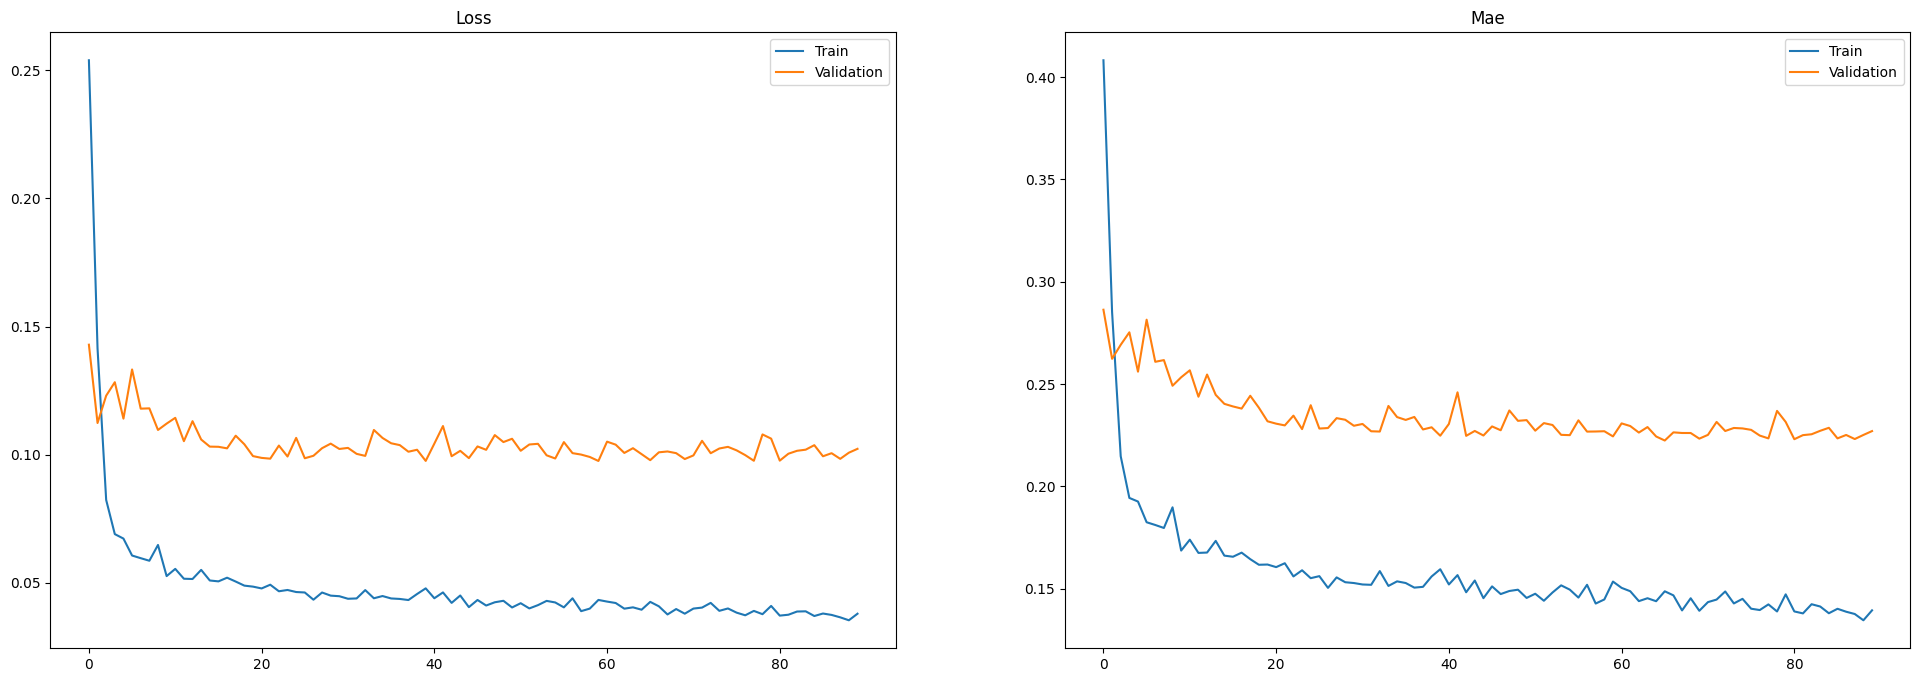

1/1 [==============================] - 2s 2s/step


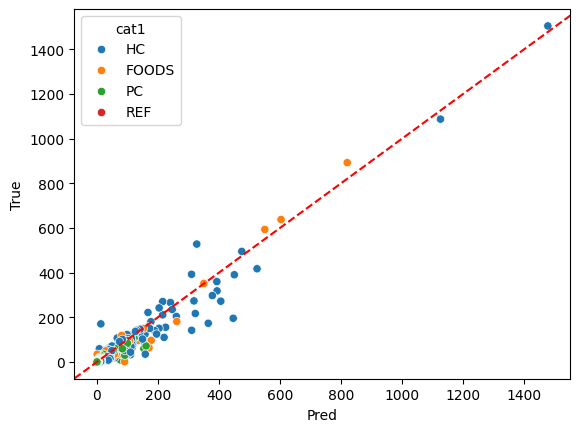

cat1
PC       723
HC       296
FOODS    230
REF       13
Name: count, dtype: int64


,tn_diff,cat1
20008,251.22,HC
20032,200.67,HC
20012,191.66,HC
20018,168.73,HC
20127,157.52,HC
20014,133.87,HC
20236,123.68,HC
20028,110.14,HC
20006,107.38,HC
20037,107.19,FOODS


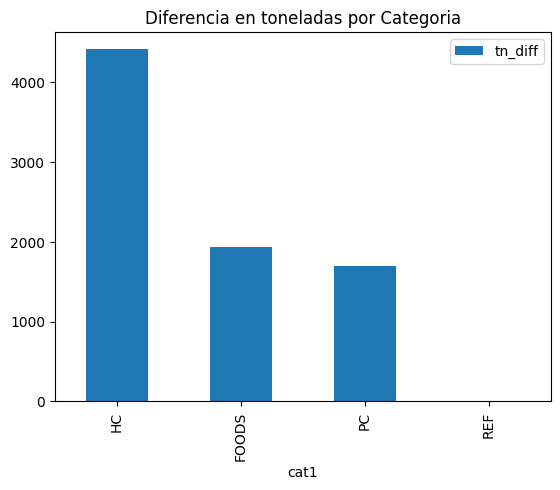

In [64]:
# # # # #########################################################################
# # # # Train hasta 2019-10, para predecir 2019-12
# # # # #########################################################################
data_train, data_valid = split_data(data_norm)
data_train_windowed = windowed_dataset(data_train, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
data_valid_windowed = windowed_dataset(data_valid, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size,)

# Model Variables
model_name = 'Clase3'
loss = 'mse'
optimizer = 'adam'
patience = 30
epochs = 500

callbacks = MyCallbacks(patience)
model = MyModel(loss, optimizer, window_size, horizon, n_features)
print(n_features)

history = model.fit(
    data_train_windowed,
    validation_data = data_valid_windowed,
    callbacks = callbacks,
    verbose=0,
    epochs=epochs)

plot_history(history)

# No sirve para este caso, esta hardcodeada a Febrero 2020. Tengo que actualizar esta funcion
# generate_predictions(data_norm, data_norm_params)

# Seleccionar los últimos x meses de data_train
data_for_prediction = data_train[-window_size:]
# Convierte los datos a un formato compatible con la función window_dataset
data_for_prediction = data_for_prediction.values.reshape((1, window_size, n_features))
predictions = model.predict(data_for_prediction)

# Convertir las predicciones a un DataFrame para desnormalizar
predictions_df = pd.DataFrame(predictions[0], columns=data_train.columns)

# Desnormalizar las predicciones
predictions_denorm = denormalize_series(predictions_df, data_norm_params, normalization=normalization)

# Imprimir las predicciones desnormalizadas
# display(predictions_denorm)


# Genero las Series para plotear el error entre predicho y real. Armo un Dataframe
data_dec2019_pred = pd.Series(predictions_denorm.iloc[1], name='Pred')
data_dec2019_true = pd.Series(data_grouped.fillna(0).loc['2019-12-01'], name='True')
data_dec2019_error = pd.concat([data_dec2019_pred, data_dec2019_true], axis=1)

# Clusterizo por Categorias 1 y 2 de productos
data_productos_indexed = data_productos.drop_duplicates('product_id').set_index('product_id').sort_index()
data_dec2019_error_detail = data_dec2019_error.join(data_productos_indexed[['cat1', 'cat2', 'cat3']])

# Ploteo los Errores, con sus clusters
sns.scatterplot(data=data_dec2019_error_detail, x='Pred', y='True', hue='cat1')
plt.axline((0, 0), slope=1, color='r', linestyle='--')
plt.show()

# Verificamos que Categoria es la que engloba mas productos
print(data_productos['cat1'].value_counts())

# Productos con mayores diferencias en la prediccion
predictions_worst10 = abs(data_dec2019_pred - data_dec2019_true).sort_values(ascending=False).head(10)
display(pd.DataFrame(predictions_worst10).join(data_productos[['product_id', 'cat1']].set_index('product_id').sort_index()).rename(columns={0: 'tn_diff'}).sort_values(by='tn_diff', ascending=False))

# Ploteamos el error en las predicciones acumulaod por Categoria
pd.DataFrame(abs(data_dec2019_pred - data_dec2019_true).sort_values(ascending=False)).join(data_productos[['product_id', 'cat1']].set_index('product_id').sort_index()).rename(columns={0: 'tn_diff'}).groupby('cat1').sum().sort_values(by='tn_diff', ascending=False).plot(kind='bar')
plt.title('Diferencia en toneladas por Categoria')
plt.show()

- Vemos claramente como estsamos prediciendo mal los productos de Health Care, mas que nada los que predice entre 350 y 600, esta prediciendo bastante de menos.

### 06/10 - Cada cliente por separado

In [23]:
# Esto lo corro en mi maquina local, en Colab se cuelga antes de terminar con los casi 600 clientes

# # Inicializo el vector de predicciones
# predicciones_all = data_productos_a_predecir.copy()
# predicciones_all['tn'] = 0

# # Probamos solo con los 3 primeros clientes
# customers = data['customer_id'].unique()
# i = 0

# for customer in customers:
#   print('Vuelta: ', i)
#   i += 1
#   data_customer = data_filter.query('customer_id == @customer')
#   data_customer_grouped = group_data(data_customer, 'product_id')
#   data_customer_grouped_fixed = complete_sales(data_customer_grouped, data_productos_a_predecir)
#   data_customer_filled = fill_nulls(data_customer_grouped_fixed) # Probar cual funciona mejor
#   # data_customer_filled = fill_nulls_customer(data_customer_grouped_fixed) # Probar cual funciona mejor
#   data_customer_norm, data_customer_norm_params = normalize_data(data_customer_filled, normalization=normalization)

#   data_train_windowed = window_dataset(data_customer_norm, data_split='train', window_size=window_size, batch_size=batch_size, n_future=n_future)

#   # Model Variables
#   model_name = 'M1'
#   loss = 'mse'
#   optimizer = 'adam'
#   patience = 30
#   epochs = 10

#   model = MyModel(loss, optimizer, window_size, n_future, n_features)

#   history = model.fit(
#       data_train_windowed,
#       # validation_data = data_valid_windowed,
#       # callbacks = callbacks,
#       verbose=2,
#       epochs=epochs)

#   predicciones = generate_predictions(data_customer_norm, data_customer_norm_params)

#   predicciones_all = sumar_predicciones(predicciones_all, predicciones)

# predicciones_all.to_csv('/content/drive/MyDrive/Universidad Austral (Resumenes)/predicciones2.csv', header=True, index=False)

### 06/10 - No Split

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 3, 64)             149824    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 bidirectional_2 (Bidirecti  (None, 1, 64)             24832     
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 32)                10368     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                      

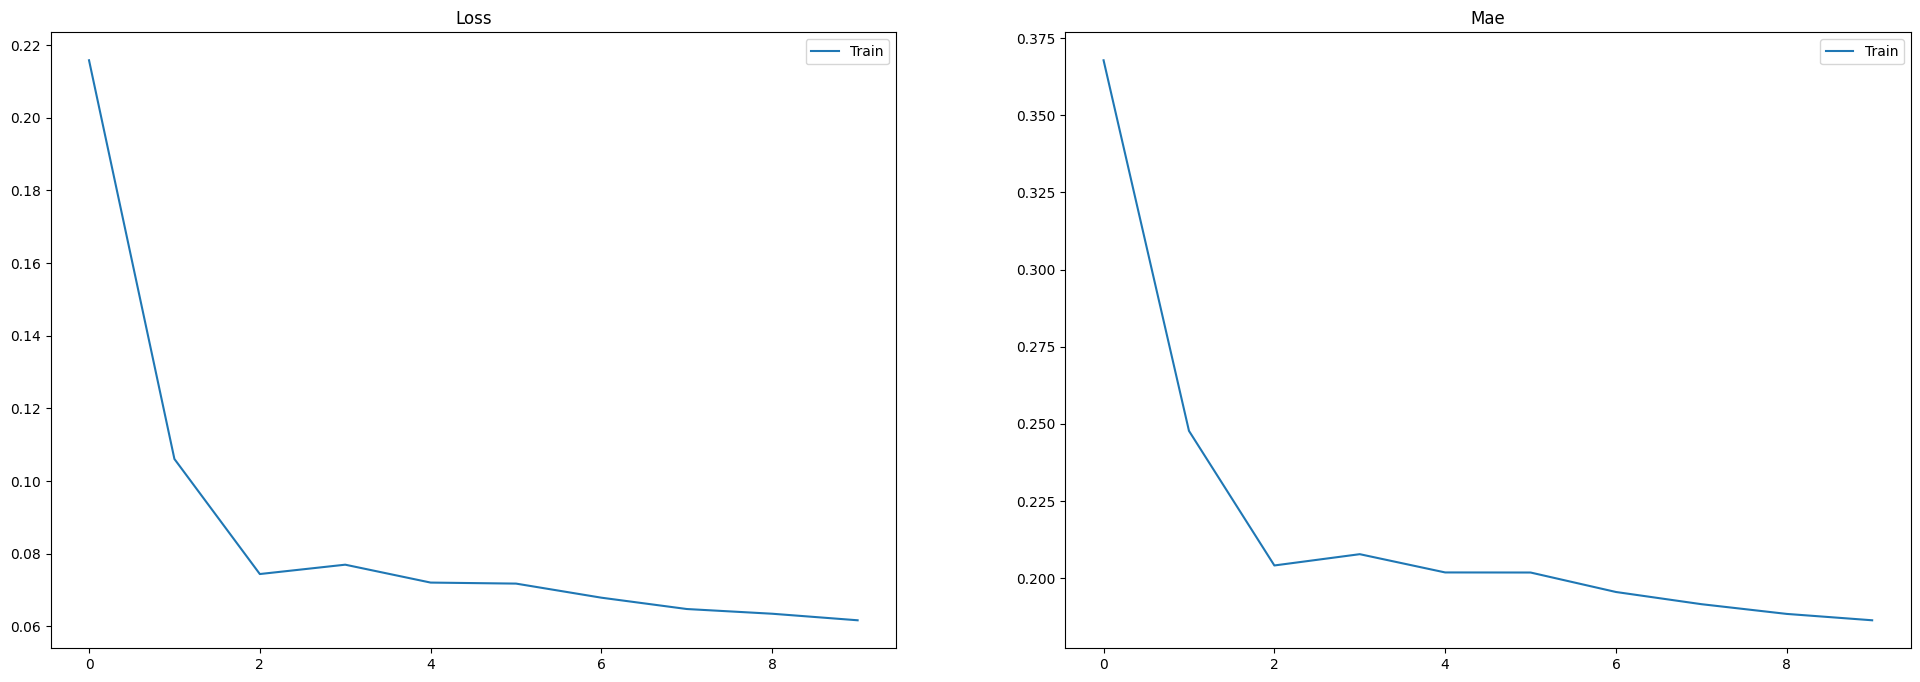

1/1 [==============================] - 0s 21ms/step
S1_M1_win3_batch1_MinMax_mse.csv


,product_id,tn
0,20001,1301.24
1,20002,941.24
2,20003,778.67
3,20004,636.20
4,20005,563.74
...,...,...
775,21263,0.26
776,21265,0.02
777,21266,0.04
778,21267,0.14


In [24]:
# # #########################################################################
# # Sin Splitear los datos, usando todo para entrenar
# # #########################################################################

data_train_windowed = windowed_dataset(data_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
# data_train_windowed = window_dataset(data_norm, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)

# Model Variables
model_name = 'M1'
# loss = 'mse'
# optimizer = 'adam'
# patience = 30
epochs = 10

model = MyModel(loss, optimizer, window_size, horizon, n_features)


history = model.fit(
    data_train_windowed,
    # validation_data = data_valid_windowed,
    # callbacks = callbacks,
    verbose=2,
    epochs=epochs)

plot_history(history)
predicciones = generate_predictions(True)
predicciones

### 06/10 - Split #2

In [25]:
# # # #########################################################################
# # # Train desde 2017-01 hasta 2019-06
# # # #########################################################################

# data_train, data_valid = split_data_2(data_norm)
# data_train_windowed = window_dataset(data_train, data_split='train', window_size=window_size, batch_size=batch_size, n_future=n_future)
# data_valid_windowed = window_dataset(data_valid, data_split='valid', window_size=window_size, batch_size=batch_size, n_future=n_future)

# # Model Variables
# model_name = 'M1'
# loss = 'mse'
# optimizer = 'adam'
# patience = 30
# epochs = 500

# callbacks = MyCallbacks(model_name, patience)
# model = MyModel(loss, optimizer, window_size, n_future, n_features)


# history = model.fit(
#     data_train_windowed,
#     validation_data = data_valid_windowed,
#     callbacks = callbacks,
#     verbose=2,
#     epochs=epochs)

# generate_predictions()

### 06/10 - Split #1

In [26]:
# # # #########################################################################
# # # Train 2018 & 2018, Validation 2019 (10/06)
# # # #########################################################################
data_train, data_valid = split_data_1(data_norm)
data_train_windowed = windowed_dataset(data_train, data_split='train', window_size=window_size, horizon=horizon, batch_size=batch_size)
data_valid_windowed = windowed_dataset(data_valid, data_split='valid', window_size=window_size, horizon=horizon, batch_size=batch_size)

# Model Variables
model_name = 'M1'
loss = 'mse'
optimizer = 'adam'
patience = 30
epochs = 500

callbacks = MyCallbacks(patience)
model = MyModel(loss, optimizer, window_size, horizon, n_features)

history = model.fit(
    data_train_windowed,
    validation_data = data_valid_windowed,
    callbacks = callbacks,
    verbose=2,
    epochs=epochs)

plot_history(history)
preddicciones = generate_predictions(True)
preddicciones

NameError: name 'split_data_1' is not defined

### Univariate: Product 20001

In [ ]:
# data = data_filled[['20001']]

# # Parámetros
# window_size = 6  # Tamaño de la ventana de tiempo
# n_future = 2  # Número de pasos futuros a predecir
# batch_size = 32
# n_splits = 5  # Número de divisiones para validación "walk forward"
# n_features = data.shape[1]  # Número de características en el conjunto de datos

# data_norm, data_norm_params = normalize_data(data, normalization=normalization)
# data_norm

### Proof of Concept

In [ ]:
# #########################################################################
# # New Pipeline (09/06)
# #########################################################################
# data_norm, data_norm_params = normalize_data(data_filled, normalization=normalization)
# # data_train, data_valid = split_data(data_norm) # Split pendiente
# data_train = data_norm
# print(data_train.shape)
# # print(data_valid.shape)
# data_train_windowed = window_dataset(data_train, data_split='train', window_size=window_size, batch_size=batch_size, n_future=n_future)
# # data_valid_windowed = window_dataset(data_valid, data_split='valid', window_size=window_size, batch_size=batch_size, n_future=n_future)


# #########################################################################
# # Old Pipeline (08/06)
# #########################################################################
# # data_all = group_data(data, data_productos_a_predecir)
# # data_all_norm, data_all_norm_params = normalize_data(data_all, normalization=normalization)
# # data_all_norm['20001'].describe()
# # data_train, data_valid = split_data_all(data_all_norm)
# # print(data_train.shape)
# # print(data_valid.shape)
# # data_train = data_all_norm
# # data_train_windowed = window_dataset(data_train, data_split='train', window_size=window_size, batch_size=batch_size, n_future=n_future)
# # data_valid_windowed = window_dataset(data_valid, data_split='valid', window_size=window_size, batch_size=batch_size, n_future=n_future)


# #########################################################################
# # Modelo
# #########################################################################
# data_train, data_valid = split_data_1(data_norm)
# data_train_windowed = window_dataset(data_train, data_split='train', window_size=window_size, batch_size=batch_size, n_future=n_future)
# data_valid_windowed = window_dataset(data_valid, data_split='valid', window_size=window_size, batch_size=batch_size, n_future=n_future)

# # Model Variables
# model_name = 'M1'
# loss = 'mse'
# optimizer = 'adam'
# patience = 30
# epochs = 500

# callbacks = MyCallbacks(model_name, patience)
# model = MyModel(loss, optimizer, window_size, n_future, n_features)

# history = model.fit(
#     data_train_windowed,
#     validation_data = data_valid_windowed,
#     callbacks = callbacks,
#     verbose=2,
#     epochs=epochs)

# generate_predictions()

# EDA

In [ ]:
# # Evidentemente cuando el profe deidentifico los customers, lo hizo asignandoles ID secuenciales al listado ordenado por la suma de ventas(tn)
# print('Listado de Clientes, ordenados por la sumatoria de ventas en tn:\n', group_data(data, 'customer_id').sum(), '\n')

# # Lo mismo cuando deidentifico a los productos, solo que esta vez empezo desde 20000
# print('Listado de Productos, ordenados por la sumatoria de ventas en tn:\n', group_data(data, 'product_id').sum())

In [ ]:
# # Analisis del cliente top

# data_top = data.query('customer_id == "10001"')
# data_top = group_data(data_top, 'product_id')
# data_top = fill_nulls(data_top)

# # data_top